In [7]:
import numpy as np
import os
from random import shuffle
import cv2
from tqdm import tqdm

TRAIN_DIR = 'data/dc/train'
TEST_DIR = 'data/dc/test'
IMG_SIZE = 50
LR = 1e-3
MODEL_NAME = 'DOGSVSCATS-{}-{}.model'.format(LR, '2conv-basic')

def label_img(img):
    word_label=img.split('.')[-3]
    if word_label=='cat':return [1,0]
    elif word_label=='dog':return [0,1]


def create_training_data():
    training_data = []
    for img in tqdm(os.listdir(TRAIN_DIR)):
        label = label_img(img)
        path = os.path.join(TRAIN_DIR,img)
        img=cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        training_data.append([np.array(img),np.array(label)])
    shuffle(training_data)
    #np.save('training_data1.npy',training_data)
    return training_data

def process_test_data():
    testing_data=[]
    for img in tqdm(os.listdir(TEST_DIR)):
        path = os.path.join(TEST_DIR,img)
        img_num = img.split('.')[0]
        img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        testing_data.append([np.array(img),np.array(img_num)])
    shuffle(testing_data)
    #np.save('test_data.npy',testing_data)
    return testing_data


train_data = create_training_data()

100%|███████████████████████████████████████████████████████████████████████████| 25000/25000 [01:18<00:00, 317.30it/s]


In [9]:
import tflearn
from tflearn.layers.conv import conv_2d,max_pool_2d
from tflearn.layers.core import input_data,dropout,fully_connected
from tflearn.layers.estimator import regression

convnet = input_data(shape=[None, IMG_SIZE, IMG_SIZE, 1], name='input')

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 32, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = conv_2d(convnet, 64, 5, activation='relu')
convnet = max_pool_2d(convnet, 5)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet,2,activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=LR, loss='categorical_crossentropy',
                          name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

C:\Users\ktm\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [11]:
if(os.path.exists('{}.meta'.format(MODEL_NAME))):
    model.load(MODEL_NAME)
    print('Model loaded')

train = train_data[:-500]
test  = train_data[-500:]

X = np.array([i[0] for i in train]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
Y = [i[1] for i in train]

test_x = np.array([i[0] for i in test]).reshape(-1,IMG_SIZE,IMG_SIZE,1)
test_y = [i[1] for i in test]

model.fit({'input':X},{'targets':Y},n_epoch=4,validation_set=({'input':test_x},{'targets':test_y}),
          snapshot_step=50000,show_metric=True,run_id=MODEL_NAME)


Training Step: 1531  | total loss: 0.41112 | time: 74.305s
| Adam | epoch: 004 | loss: 0.41112 - acc: 0.8089 -- iter: 24448/24500
Training Step: 1532  | total loss: 0.41458 | time: 75.501s
| Adam | epoch: 004 | loss: 0.41458 - acc: 0.8108 | val_loss: 0.48193 - val_acc: 0.7900 -- iter: 24500/24500
--


100%|███████████████████████████████████████████████████████████████████████████| 12500/12500 [00:29<00:00, 419.19it/s]


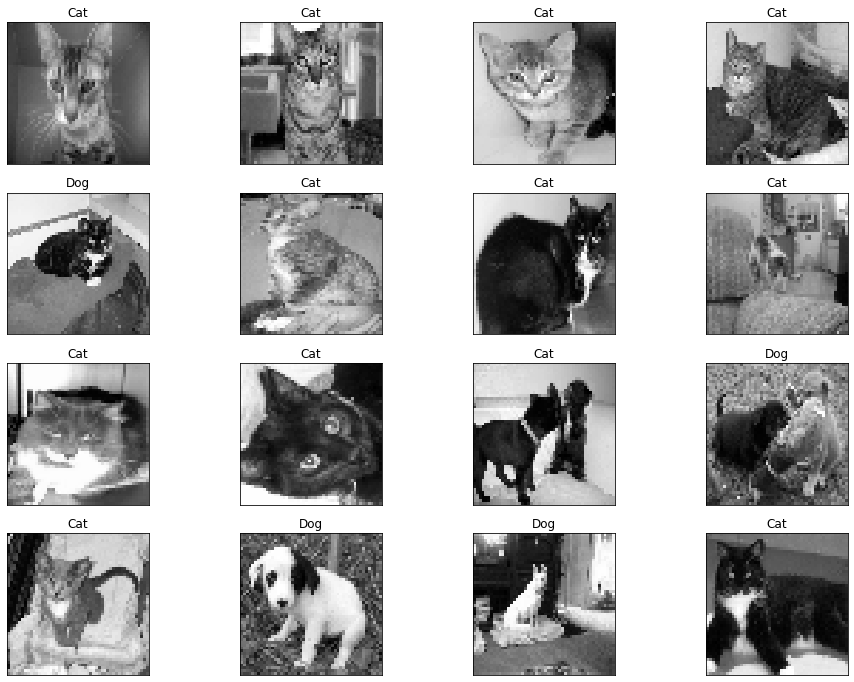

In [16]:
import matplotlib.pyplot as plt
test_data = process_test_data()
fig=plt.figure(figsize=(16, 12))
for num, data in enumerate(test_data[:16]):
    
    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(4, 4, num+1)
    orig = img_data
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1)
    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == 1: 
        str_label='Dog'
    else:
        str_label='Cat'
        
    y.imshow(orig, cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()